**Table of contents**<a id='toc0_'></a>    
- [ADCGs](#toc1_)    
  - [Packages](#toc1_1_)    
  - [Important Variables](#toc1_2_)    
  - [Pulse Shape for Single Pulse](#toc1_3_)    
    - [Graphed pulse shape](#toc1_3_1_)    
  - [Control Profile](#toc1_4_)    
    - [Graphed original control profiles](#toc1_4_1_)    
  - [Hamiltonian Defined](#toc1_5_)    
  - [Trotterisation](#toc1_6_)    
    - [Check values for trotterisation](#toc1_6_1_)    
  - [F_dist Function](#toc1_7_)    
      - [F objective function tests](#toc1_7_1_1_)    
  - [Creation of G Functions](#toc1_8_)    
    - [G Function opt check](#toc1_8_1_)    
  - [Objective Function](#toc1_9_)    
      - [Objective function testing](#toc1_9_1_1_)    
  - [Corrected Optimisation](#toc1_10_)    
  - [Corrected Imperfect and Perfect \delta J = 0.01 or 0.0](#toc1_11_)    
    - [\delta J_t imperf](#toc1_11_1_)    
    - [\deltaJ_t_perf](#toc1_11_2_)    
  - [Graphing](#toc1_12_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[ADCGs](#toc0_)

## <a id='toc1_1_'></a>[Packages](#toc0_)

In [5]:
# packages needed
using QuantumOptics
using LinearAlgebra
# using KrylovKit
using OptimizationOptimJL
using Optimization
using Random
using Statistics
using ColorSchemes
using Plots
# using Plots.PlotMeasures
# using NPZ

## <a id='toc1_2_'></a>[Important Variables](#toc0_)

In [43]:
h = [0.89, 0.45, 0.25, 0.87, 0.25, 0.97, 0.48, 0.85, 0.8, 0.2, 0.87, 0.18, 0.98, 0.5, 0.38, 0.99, 0.2]
c = [0.0, 0.1, 0.8, 0.9, 1.0, 1.0, 1.0, 0.9, 0.5, 0.2, 0.1, 0.0];

In [7]:
b = SpinBasis(1 // 2)
sx = sigmax(b)
sy = sigmay(b)
sz = sigmaz(b)
B = 1.0
U0 = exp(0 * sx)
J_max = 3.0
n = length(c) # number of subintervals in each pulse
N = length(h) # number of pulses
t0 = 0.0
tp = 2π * 0.3 # single pulse duration
Δtp = tp / n
T = [t0:Δtp:tp;]
Jmax = J_max;

In [8]:
# Target Gate
QU_matrix = exp(-im * π / (8) * dense(sz))

Operator(dim=2x2)
  basis: Spin(1/2)
 0.92388-0.382683im      0.0+0.0im
     0.0+0.0im       0.92388+0.382683im

## <a id='toc1_3_'></a>[Pulse Shape for Single Pulse](#toc0_)

In [45]:
function custom_pulse_shape(t)
    i = findfirst(ti -> t >= T[ti] && t < T[ti+1], 1:n-1)
    return i == nothing ? 0 : c[i]
end;

### <a id='toc1_3_1_'></a>[Graphed pulse shape](#toc0_)

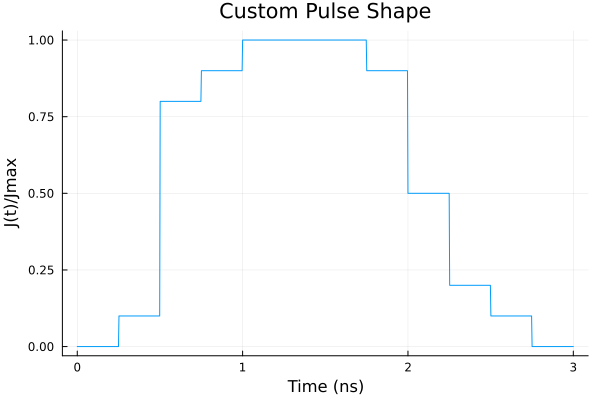

In [50]:
function custom_pulse_shape_graph(t)
    tp = 3
    n = length(c)
    Δtp = tp / n  

    phase = mod(t, tp)  # Calculate the phase within the total time

    # Find the subinterval that contains the specified time t
    subinterval_index = floor(Int, phase / Δtp) + 1

    # Ensure subinterval_index is within the valid range
    subinterval_index = max(1, min(subinterval_index, 12))

    # Calculate the plateau height within the current subinterval
    plateau_height = c[subinterval_index]

    return plateau_height
end
# Define the time points at which to evaluate the pulse shape
time_points = range(0, stop=3, length=1000)

# Evaluate the pulse shape at each time point and plot
pulse_values = [custom_pulse_shape_graph(t) for t in time_points]
plot(time_points, pulse_values, legend=false, title="Custom Pulse Shape", xlabel="Time (ns)", ylabel="J(t)/Jmax")

## <a id='toc1_4_'></a>[Control Profile](#toc0_)

In [10]:
function control_profile(t,h)
    N = length(h)
    cc = 0.0
    for i in 1:N
        cc += h[i]*c(t-tp*(i-1)) 
    end
    return cc
end

control_profile (generic function with 1 method)

### <a id='toc1_4_1_'></a>[Graphed original control profiles](#toc0_)

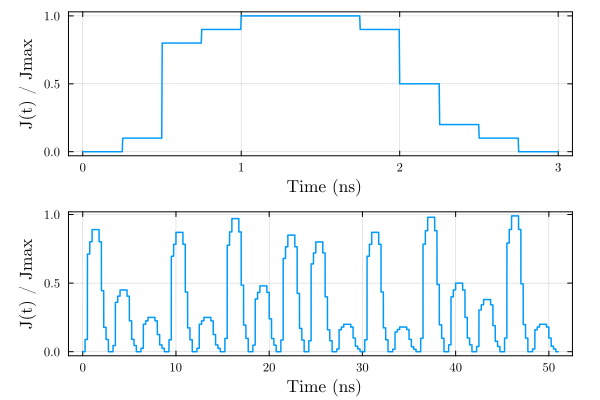

In [60]:
# Generate Plot 
time_points = range(0, stop=3, length=1000)
pulse_values = [custom_pulse_shape_graph(t) for t in time_points]
plot2 = plot(time_points, pulse_values, title="", xlabel=" Time (ns)", ylabel="J(t) / Jmax", 
               legend=false, yticks=[0, 0.5, 1], framestyle=:box, 
              titlefontsize=12, linewidth=1.5, fontfamily = "Computer Modern")

# Generate Plot 1
h1 = [0.89, 0.45, 0.25, 0.87, 0.25, 0.97, 0.48, 0.85, 0.8, 0.2, 0.87, 0.18, 0.98, 0.5, 0.38, 0.99, 0.2]
lp1 = length(h1)
t1 = range(0, stop=lp1*3, length=10000)
y1 = control_profile.(t1, custom_pulse_shape_graph, Ref(h1))
plot1 = plot(t1, y1, title="", xlabel=" Time (ns)", ylabel="J(t) / Jmax",  
            legend=false, yticks=[0, 0.5, 1], framestyle=:box, titlefontsize=12, linewidth=1.5, fontfamily = "Computer Modern")

# Define the layout
l = @layout [a ; b]

# Create the combined plot with a custom overall size
combined_plot = plot(plot2, plot1, layout=l, size=(600, 400), left_margin=[5mm 5mm], right_margin=5mm)

# Show the plot (this may be optional depending on your setup)
display(combined_plot)

## <a id='toc1_5_'></a>[Hamiltonian Defined](#toc0_)

In [11]:
# Define the control pulse J(t)
function J(t, h)
    return control_profile(t, custom_pulse_shape, h) * J_max   # * is for J_max/B 
end

# Hamiltonian δ=0
function H_t(t, h)
    return (1 / 2 * B * dense(sx) + 1 / 2 * J(t, h) * dense(sz))
end

H_t (generic function with 1 method)

## <a id='toc1_6_'></a>[Trotterisation](#toc0_)

In [12]:
function trotterize(h::Vector{Float64})


    U = Array{Operator}(undef, n*N) # Initialise U array - where n is subintervals

    H0i(i,k) = 0.5 * B * sx + 0.5 * J_max * h[k] * c[i] * sz # Adjusted H0i calculation
   
    counter = 1

    for k in 1:N
       for i in 1:n
           U[counter] = exp(-im * dense(H0i(i, k)) * (T[i+1]-T[i]))
           counter += 1
       end
    end

    return prod(reverse(U))
end;

### <a id='toc1_6_1_'></a>[Check values for trotterisation](#toc0_)

In [63]:
#n=3 pulses
function trotterize_3n(h::Vector{Float64})

    N = length(h)

    U = Array{Operator}(undef,n*N); # where n is the number of subintervals in each pulse
    H0i(i,j) = 0.5*B*sx + 0.5*Jmax*h[j]*C[i]*sz
    counter = 1

    for j in 1:N
        for i in 1:n
            U[counter] = exp(-im*dense(H0i(i,j))*Δtp)
            counter += 1
        end
    end
    return prod(reverse(U))
end;
# Optimised uncorrected pulse heights
h = [0.5244952986322989, 0.27739529922375394, 0.496236723882969]
U0_t_f = trotterize_3n(h)

Operator(dim=2x2)
  basis: Spin(1/2)
   -0.92388+0.382683im    6.3713e-9+2.46909e-9im
 -6.3713e-9+2.46909e-9im   -0.92388-0.382683im

In [61]:
# n=17 pulses
# Optimised corrected pulse heights
h = [0.8541780947860196
0.8225898702690786
0.36769089968139945
0.8845220696655625
0.46730033219524036
0.7812801722780498
0.30599177907885156
0.39235317207342424
0.9017263716406293
0.1558992112077194
0.9132765142104099
0.4814238404261615
0.5598494881728675
0.8400138505024556
0.48181004908787955
0.8081718940312103
0.07194968663602934];
U0_t_f = trotterize(h)

Operator(dim=2x2)
  basis: Spin(1/2)
    0.92388-0.382683im    -3.91352e-8+8.26934e-9im
 3.91352e-8+8.26934e-9im      0.92388+0.382683im

## <a id='toc1_7_'></a>[F_dist Function](#toc0_)

In [13]:
function dist(U, V)
    d = 2
    trace_UV = abs(tr((U)' * V))
    return sqrt(abs(1 - trace_UV / d))
end

dist (generic function with 1 method)

In [14]:
function F_dist(h, c)
   
    U0_t_f = trotterize(h)

   # Calculate distance between U0 and target matrix Q
    distance = dist(U0_t_f, QU_matrix)

    return distance
end

F_dist (generic function with 1 method)

In [15]:
function F_obj(U_tot)

    distance = dist(U_tot, QU_matrix)

    return distance
end

F_obj (generic function with 1 method)

#### <a id='toc1_7_1_1_'></a>[F objective function tests](#toc0_)

In [64]:
h = [0.89, 0.45, 0.25, 0.87, 0.25, 0.97, 0.48, 0.85, 0.8, 0.2, 0.87, 0.18, 0.98, 0.5, 0.38, 0.99, 0.2]
F_dist(h, c)

0.3999042600820655

In [65]:
h = [0.8541780947860196, 0.8225898702690786, 0.36769089968139945, 0.8845220696655625,
0.46730033219524036, 0.7812801722780498, 0.30599177907885156, 0.39235317207342424,
0.9017263716406293, 0.1558992112077194, 0.9132765142104099, 0.4814238404261615,
0.5598494881728675, 0.8400138505024556, 0.48181004908787955,
0.8081718940312103, 0.07194968663602934];
F_dist(h, c)

1.4901161193847656e-8

In [73]:
# n=3 pulses
function F_dist2(h, p)
    # Define the time span
    t0 = 0.0
    t = 0.9*2π
    Δtp = 0.15707963267948966
    p = exp(-im*π/(8) * dense(sz))
 
     U0_t_f = trotterize_3n(h)   
     
     # Calculate distance between U0 and target matrix Q
     distance = dist(U0_t_f, QU_matrix)
 
     return distance
 end

F_dist2 (generic function with 1 method)

In [76]:
h = [0.89, 0.45, 0.25]
F_dist2(h, p)

0.4615859838818423

In [75]:
h =  [0.5244952986322989, 0.27739529922375394, 0.496236723882969] 
F_dist2(h, p)

0.0

## <a id='toc1_8_'></a>[Creation of G Functions](#toc0_)

In [16]:
hc = [h[i] * c for i in 1:N]
hcik = vcat(hc...);

In [17]:
# Define integration function
function Integration(hcik, j)
     
    γ = sqrt((hcik * J_max)^2 + B^2)
    a1 = 0.5 * B
    a3 = 0.5 * hcik * J_max

    if j == 1
        ad_A_B = im * a3 * sy
        ad_A2_B = 2 * (a3 * ((a3 * sx) - (a1 * sz)))
        B_use = 0.5 * sx
    elseif j == 2
        ad_A_B = -2im * (a1 * sy * a3)
        ad_A2_B = -4 * (a1 * ((a3 * sx) - (a1 * sz)) * a3)
        B_use = (a3 * sz)
    end



    Final_term = (B_use * Δtp) - im * ((cos(γ * Δtp) - 1) / (γ^2)) * ad_A_B + ((sin(γ * Δtp) - (γ * Δtp)) / (γ^3)) * ad_A2_B
    result = Final_term
   
    return result
end
# Ijk = Integration(hc, j)

Integration (generic function with 1 method)

In [18]:
function cumulative_products(U)

    n = length(U)
    products = Array{Operator}(undef,n)
    products[1] = U[1]
    for i in 2:n
        products[i] = U[i]*products[i-1]
    end

    return products
end;

In [19]:
function G_functions(Cumulative_prod, hcik, j)
    
    s = Array{Operator}(undef, n*N)


    for i in 1:n*N
        s[i] = (Cumulative_prod[i])' * Integration(hcik[i], j) * Cumulative_prod[i]
    end

    eigenvalues = eigen(sum(s).data).values

    return maximum(abs.(eigenvalues)) 
end

G_functions (generic function with 1 method)

### <a id='toc1_8_1_'></a>[G Function opt check](#toc0_)

In [26]:
# Function to optimize
# valid for an arbitrary number of pulses

function F_opt(h, c)

    N = length(h)
    n = length(c)
    # I know n and N beforehand, so probably better not to redifine them every time.

    U = Array{Operator}(undef, n*N) # Initialise U array - where n is subintervals

    H0i(i,k) = 0.5 * B * sx + 0.5 * J_max * h[k] * c[i] * sz # Adjusted H0i calculation
   
    counter = 1

    for k in 1:N
       for i in 1:n
           U[counter] = exp(-im * dense(H0i(i, k)) * (T[i+1]-T[i]))
           counter += 1
       end
    end


    QU_matrix = exp(-im * π / (8) * dense(sz))
    
    return sqrt( abs( 1 - abs( tr(dagger(QU_matrix) * prod(reverse(U))) ) /2 ) )

end;

In [35]:
function G1_opt(h, c)

    N = length(h)
    n = length(c)

    hc = [h[i] * c for i in 1:N]
    hcik = vcat(hc...)

    # the unitary operators could be calculated directly in the cumulative_products function
    H0ik(i) = 0.5 * B * sx + 0.5 * Jmax * hcik[i] * sz
    U = Array{Operator}(undef,n*N) # where n is the number of subintervals in each pulse
    for i in 1:n*N
        U[i] = exp(-im * dense(H0ik(i)) * Δtp) # check if I could just make an update of U in an efficient way
    end
    pushfirst!(U, U0)

    Cumulative_prod = cumulative_products(U)

    return G_functions(Cumulative_prod, hcik, 1)

end;

In [36]:
function G2_opt(h, c)

    N = length(h)
    n = length(c)

    hc = [h[i] * c for i in 1:N]
    hcik = vcat(hc...)

    # the unitary operators could be calculated directly in the cumulative_products function
    H0ik(i) = 0.5 * B * sx + 0.5 * Jmax * hcik[i] * sz
    U = Array{Operator}(undef,n*N) # where n is the number of subintervals in each pulse
    for i in 1:n*N
        U[i] = exp(-im * dense(H0ik(i)) * Δtp) # check if I could just make an update of U in an efficient way
    end
    pushfirst!(U, U0)

    Cumulative_prod = cumulative_products(U)

    return G_functions(Cumulative_prod, hcik, 2)

end;

## <a id='toc1_9_'></a>[Objective Function](#toc0_)

In [20]:
function objective_function1(h, c)
    N = length(h)
    n = length(c)  # n is the number of subintervals in each pulse

    hc = [h[i] * c for i in 1:N]
    hcik = vcat(hc...)

    # the unitary operators could be calculated directly in the cumulative_products function
    H0ik(i) = 0.5 * B * sx + 0.5 * Jmax * hcik[i] * sz
    U = Array{Operator}(undef,n*N) # where n is the number of subintervals in each pulse
    for i in 1:n*N
        U[i] = exp(-im*dense(H0ik(i))*Δtp) # check if I could just make an update of U in an efficient way
    end
    pushfirst!(U, U0)

    Cumulative_prod = cumulative_products(U)

    λ1 = 1e-5
    λ2 = 1e-5
    
    F_term = F_obj(last(Cumulative_prod))
    G1_term = λ1 * G_functions(Cumulative_prod, hcik, 1)
    G2_term = λ2 * G_functions(Cumulative_prod, hcik, 2)

    return F_term + G1_term + G2_term
end

objective_function1 (generic function with 1 method)

In [ ]:
function objective_function2(h, c)
    N = length(h)
    n = length(c)  # n is the number of subintervals in each pulse

    hc = [h[i] * c for i in 1:N]
    hcik = vcat(hc...)

    # the unitary operators could be calculated directly in the cumulative_products function
    H0ik(i) = 0.5 * B * sx + 0.5 * Jmax * hcik[i] * sz
    U = Array{Operator}(undef,n*N) # where n is the number of subintervals in each pulse
    for i in 1:n*N
        U[i] = exp(-im*dense(H0ik(i))*Δtp) # check if I could just make an update of U in an efficient way
    end
    pushfirst!(U, U0)

    Cumulative_prod = cumulative_products(U)

    λ1 = 1
    λ2 = 0.0001795355
    
    F_term = F_obj(last(Cumulative_prod))
    G1_term = λ1 * G_functions(Cumulative_prod, hcik, 1)
    G2_term = λ2 * G_functions(Cumulative_prod, hcik, 2)

    return F_term + G1_term + G2_term
end

In [ ]:
function objective_function3(h, c)
    N = length(h)
    n = length(c)  # n is the number of subintervals in each pulse

    hc = [h[i] * c for i in 1:N]
    hcik = vcat(hc...)

    # the unitary operators could be calculated directly in the cumulative_products function
    H0ik(i) = 0.5 * B * sx + 0.5 * Jmax * hcik[i] * sz
    U = Array{Operator}(undef,n*N) # where n is the number of subintervals in each pulse
    for i in 1:n*N
        U[i] = exp(-im*dense(H0ik(i))*Δtp) # check if I could just make an update of U in an efficient way
    end
    pushfirst!(U, U0)

    Cumulative_prod = cumulative_products(U)

    λ1 = 1
    λ2 = 1
    
    F_term = F_obj(last(Cumulative_prod))
    G1_term = λ1 * G_functions(Cumulative_prod, hcik, 1)
    G2_term = λ2 * G_functions(Cumulative_prod, hcik, 2)

    return F_term + G1_term + G2_term
end

#### <a id='toc1_9_1_1_'></a>[Objective function testing](#toc0_)

In [31]:
# Optimised pulse heights
h4 = [0.8541780947860196
0.8225898702690786
0.36769089968139945
0.8845220696655625
0.46730033219524036
0.7812801722780498
0.30599177907885156
0.39235317207342424
0.9017263716406293
0.1558992112077194
0.9132765142104099
0.4814238404261615
0.5598494881728675
0.8400138505024556
0.48181004908787955
0.8081718940312103
0.07194968663602934]

objective_function1(h4, c)

1.8697609254859917e-13

## <a id='toc1_10_'></a>[Corrected Optimisation](#toc0_)

In [34]:
# params
λ1 = 1e-5
λ2 = 1e-5
#optimisation 1
N = 17
h0 = [0.89, 0.45, 0.25, 0.87, 0.25, 0.97, 0.48, 0.85, 0.8, 0.2, 0.87, 0.18, 0.98, 0.5, 0.38, 0.99, 0.2] # no control pulse
lb = zeros(N)
ub = ones(N)

f1 = OptimizationFunction(objective_function1, Optimization.AutoForwardDiff())
prob1 = OptimizationProblem(f1, h0, c, lb = lb, ub = ub)
sol1 = solve(prob1, Optim.SAMIN(), maxiters=1e5)
h0_2 = sol1.minimizer

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 82451

     Obj. value:      0.0001202258

       parameter      search width
         0.08885           0.00000 
         0.32074           0.00000 
         0.13520           0.00000 
         0.32059           0.00000 
         0.31086           0.00000 
         0.37988           0.00000 
         0.22390           0.00000 
         0.97750           0.00000 
         0.56036           0.00000 
         0.65370           0.00000 
         0.20245           0.00000 
         0.82615           0.00000 
         0.13330           0.00000 
         0.23295           0.00000 
         0.61038           0.00000 
         0.73870           0.00000 
         0.76411           0.00000 



17-element Vector{Float64}:
 0.08884855965119012
 0.3207434740603948
 0.13520029168644127
 0.32058991881895227
 0.31085936579989226
 0.37988072363672826
 0.2238983054993241
 0.9774998990534163
 0.5603637523127946
 0.6536979394314312
 0.20244735766183633
 0.8261458459273106
 0.1333035553061024
 0.2329491763995176
 0.6103799800063241
 0.7387047965398018
 0.7641139725482727

In [37]:
# Check values for F, G1 & G2 for Optim1
println(F_opt(h0_2, c), " ", G1_opt(h0_2, c), " ", G2_opt(h0_2, c))

2.1073424255447017e-8 8.787873735842172 3.234707277306414


In [38]:
# params
λ1 = 1
λ2 = 1e-5
#optimisation 2
N = 17
h0_2 = sol1.minimizer # new initial guess from the result of the first optimization
lb = zeros(N)
ub = ones(N)
f2 = OptimizationFunction(objective_function2, Optimization.AutoForwardDiff())
prob2 = OptimizationProblem(f2, h0_2, c, lb = lb, ub = ub)
sol2 = solve(prob2, Optim.SAMIN(), maxiters=1e5)
h0_3 = sol2.minimizer

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 92226

     Obj. value:      0.0003472114

       parameter      search width
         0.13387           0.00000 
         0.96850           0.00000 
         0.09196           0.00000 
         0.28689           0.00000 
         0.53870           0.00000 
         0.55955           0.00000 
         0.52269           0.00000 
         0.79074           0.00000 
         0.05788           0.00000 
         0.91662           0.00000 
         0.34492           0.00000 
         0.11522           0.00000 
         0.65890           0.00000 
         0.07929           0.00000 
         0.24374           0.00000 
         0.35109           0.00000 
         0.72690           0.00000 



17-element Vector{Float64}:
 0.13386997645163237
 0.9684988599588152
 0.09196353653539695
 0.2868852402899506
 0.5386992562222511
 0.5595456281049939
 0.5226912092007894
 0.7907352501074575
 0.05787916915757733
 0.9166174950189584
 0.34491639394690515
 0.1152188710326593
 0.6588965566785673
 0.07929188103666415
 0.24373500470054543
 0.35108675946255724
 0.7268995989952752

In [39]:
# Check values for F, G1 & G2 for Optim2
println(F_opt(h0_3, c), " ", G1_opt(h0_3, c), " ", G2_opt(h0_3, c))

2.1073424255447017e-8 1.644080270176955e-9 1.9339334503248282


In [40]:
# params
λ1 = 1
λ2 = 1
#optimisation 3
N = 17
h0_3 = sol2.minimizer # new initial guess from the result of the first optimization
lb = zeros(N)
ub = ones(N)
f3 = OptimizationFunction(objective_function3, Optimization.AutoForwardDiff())
prob3 = OptimizationProblem(f3, h0_3, c, lb = lb, ub = ub)
sol3 = solve(prob3, Optim.SAMIN(), maxiters=1e5)
final_h = sol3.minimizer

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 91801

     Obj. value:      0.0000000049

       parameter      search width
         0.76643           0.00000 
         0.27345           0.00000 
         0.94687           0.00000 
         0.21619           0.00000 
         0.92123           0.00000 
         0.69658           0.00000 
         0.53738           0.00000 
         0.87329           0.00000 
         0.18728           0.00000 
         0.92218           0.00000 
         0.08756           0.00000 
         0.53689           0.00000 
         0.99821           0.00000 
         0.67604           0.00000 
         0.83878           0.00000 
         0.03174           0.00000 
         0.85827           0.00000 



17-element Vector{Float64}:
 0.7664346491478756
 0.2734483148356411
 0.9468695501152261
 0.21618637289906195
 0.9212291334683613
 0.6965832676098361
 0.5373846000591715
 0.8732860294875143
 0.18727943772105893
 0.9221830130634113
 0.0875598911302505
 0.5368889876535937
 0.998209837350102
 0.6760368126527863
 0.8387807228626514
 0.03173822627023617
 0.8582668439966771

In [41]:
# Check values for F, G1 & G2 for Optim_final
println(F_opt(final_h, c), " ", G1_opt(final_h, c), " ", G2_opt(final_h, c))

2.1073424255447017e-8 2.911047771430917e-9 1.986239146051636e-9


## <a id='toc1_11_'></a>[Corrected Imperfect and Perfect \delta J = 0.01 or 0.0](#toc0_)

In [77]:
δJ_t = 0.01
δJ_t_perf = 0.0
δB_t = [1.0*10^-5, 1.0*10^-4, 2.0*10^-4, 4.0*10^-4, 6.0*10^-4, 8.0*10^-4, 1.0*10^-3, 2.0*10^-3, 4.0*10^-3, 6.0*10^-3, 
        8.0*10^-3, 1.0*10^-2, 2.0*10^-2, 4.0*10^-2, 6.0*10^-2, 8.0*10^-2, 1.0*10^-1, 2.0*10^-1, 4.0*10^-1, 6.0*10^-1, 
        8.0*10^-1, 1.0, 1.2, 1.4];

### <a id='toc1_11_1_'></a>[\delta J_t imperf](#toc0_)

In [78]:
# Define the control pulse J(t)
function J_inc_error(t, h)
    return control_profile(t, custom_pulse_shape, h) * (1 +(δJ_t))* J_max   # * is for J_max/B with δj
end

# Hamiltonian δ=0
function H_t_inc_error(t, h, δB_t)
    return (1/2 * (B + δB_t) * dense(sx) + 1/2 * J_inc_error(t, h) * dense(sz))
end

H_t_inc_error (generic function with 1 method)

In [79]:
function trotterize_inc_error(h::Vector{Float64}, δB_t, δJ_t)


    U = Array{Operator}(undef, n*N) # Initialise U array - where n is subintervals

    H0i(i,k) = 0.5 * (B + δB_t) * sx + 0.5 * J_max * h[k] * c[i] * sz * (1 + (δJ_t)) # Adjusted H0i calculation
   
    counter = 1

    for k in 1:N
       for i in 1:n
           U[counter] = exp(-im * dense(H0i(i, k)) * (T[i+1]-T[i]))
           counter += 1
       end
    end

    return prod(reverse(U))
end;

In [80]:
function F_dist_inc_error(h, δB_t, δJ_t)
    
    U0_t_f = trotterize_inc_error(h, δB_t, δJ_t) 

    QU_matrix = exp(-im*π/(8) * dense(sz))
    
    # Calculate distance between U0 and target matrix Q
    distance = dist(U0_t_f, QU_matrix)
   
    return distance
end

F_dist_inc_error (generic function with 1 method)

In [81]:
# fidelity loss
function F_loss(h, δB_t, δJ_t)
    # Initialize an empty array to store squared results
    squared_results = Float64[]
    
    # Loop over each δB_t value in the array
    for δB_t in δB_t
        # Calculate the distance using F_dist_imperf
        distance = F_dist_inc_error(h, δB_t, δJ_t)
        
        # Square the distance
        squared_distance = distance^2
        
        # Store the squared distance in the array
        push!(squared_results, squared_distance)
    end
    
    return squared_results
end

F_loss (generic function with 1 method)

In [83]:
h = [0.8541780947860196
0.8225898702690786
0.36769089968139945
0.8845220696655625
0.46730033219524036
0.7812801722780498
0.30599177907885156
0.39235317207342424
0.9017263716406293
0.1558992112077194
0.9132765142104099
0.4814238404261615
0.5598494881728675
0.8400138505024556
0.48181004908787955
0.8081718940312103
0.07194968663602934]

# Call the F_loss function to get the squared fidelity distances
squared_fidelity_distances = F_loss(h, δB_t, δJ_t)

24-element Vector{Float64}:
 5.936402847073196e-7
 6.250154183096157e-7
 6.611729499450546e-7
 7.376956265847668e-7
 8.200262551216753e-7
 9.08406027066988e-7
 1.003080531525313e-6
 1.579777548221806e-6
 3.3590261385718634e-6
 6.224160001400136e-6
 ⋮
 0.007488900771619234
 0.01646552655191058
 0.1874442580600959
 0.7057965216517438
 0.17855198027945773
 0.10630540790468125
 0.8728873988388316
 0.5613173482010759
 0.48094058414418905

### <a id='toc1_11_2_'></a>[\deltaJ_t_perf](#toc0_)

In [84]:
# Define the control pulse J(t)
function J_inc_error(t, h)
    return control_profile(t, custom_pulse_shape, h) * (1 +(δJ_t_perf))* J_max   # * is for J_max/B with δj
end

# Hamiltonian δ=0
function H_t_inc_error(t, h, δB_t)
    return (1/2 * (B + δB_t) * dense(sx) + 1/2 * J_inc_error(t, h) * dense(sz))
end

H_t_inc_error (generic function with 1 method)

In [85]:
function trotterize_inc_error(h::Vector{Float64}, δB_t, δJ_t_perf)


    U = Array{Operator}(undef, n*N) # Initialise U array - where n is subintervals

    H0i(i,k) = 0.5 * (B + δB_t) * sx + 0.5 * J_max * h[k] * c[i] * sz * (1 + (δJ_t_perf)) # Adjusted H0i calculation
   
    counter = 1

    for k in 1:N
       for i in 1:n
           U[counter] = exp(-im * dense(H0i(i, k)) * (T[i+1]-T[i]))
           counter += 1
       end
    end

    return prod(reverse(U))
end;

In [86]:
function F_dist_inc_error(h, δB_t, δJ_t_perf)
    
    U0_t_f = trotterize_inc_error(h, δB_t, δJ_t_perf) 

    QU_matrix = exp(-im*π/(8) * dense(sz))
    
    # Calculate distance between U0 and target matrix Q
    distance = dist(U0_t_f, QU_matrix)
   
    return distance
end

F_dist_inc_error (generic function with 1 method)

In [87]:
# fidelity loss
function F_loss(h, δB_t, δJ_t_perf)
    # Initialize an empty array to store squared results
    squared_results = Float64[]
    
    # Loop over each δB_t value in the array
    for δB_t in δB_t
        # Calculate the distance using F_dist_imperf
        distance = F_dist_inc_error(h, δB_t, δJ_t_perf)
        
        # Square the distance
        squared_distance = distance^2
        
        # Store the squared distance in the array
        push!(squared_results, squared_distance)
    end
    
    return squared_results
end

F_loss (generic function with 1 method)

In [88]:
h = [0.8541780947860196
0.8225898702690786
0.36769089968139945
0.8845220696655625
0.46730033219524036
0.7812801722780498
0.30599177907885156
0.39235317207342424
0.9017263716406293
0.1558992112077194
0.9132765142104099
0.4814238404261615
0.5598494881728675
0.8400138505024556
0.48181004908787955
0.8081718940312103
0.07194968663602934]

# Call the F_loss function to get the squared fidelity distances
squared_fidelity_distances = F_loss(h, δB_t, δJ_t_perf)

24-element Vector{Float64}:
 4.440892098500627e-16
 4.5519144009631426e-15
 1.7341683644644945e-13
 2.935207632503989e-12
 1.5089707261495278e-11
 4.793865304719702e-11
 1.1734702098920025e-10
 1.8848638205781754e-9
 3.021561667537753e-8
 1.5314949908251663e-7
 ⋮
 0.0048552408614037645
 0.011718690486483442
 0.16300381058948754
 0.7391643763592506
 0.177181271531897
 0.10601814173286904
 0.831260192645167
 0.5355845017721435
 0.47064828272097736

## <a id='toc1_12_'></a>[Graphing](#toc0_)

In [89]:
using Polynomials

In [97]:
B = 1
δB_t = [1.0*10^-5, 1.0*10^-4, 2.0*10^-4, 4.0*10^-4, 6.0*10^-4, 8.0*10^-4, 1.0*10^-3, 2.0*10^-3, 
        4.0*10^-3, 6.0*10^-3, 8.0*10^-3, 1.0*10^-2, 2.0*10^-2, 4.0*10^-2, 6.0*10^-2, 8.0*10^-2, 
        1.0*10^-1, 2.0*10^-1, 4.0*10^-1, 6.0*10^-1, 8.0*10^-1, 1.0, 1.2, 1.4] / B

# Squared fidelity distances for n=3 and n=17
squared_fidelity_distances_3 = [4.69488890206815e-5, 4.8827801012452106e-5, 5.096558925909988e-5, 5.539941522370029e-5, 6.0044262465863696e-5, 
                                6.490015730520325e-5, 6.996712599605104e-5, 9.846899136389807e-5, 0.00017131816571358538, 0.0002653157652027227, 
                                0.0003804866044425647, 0.0005168548277348917, 0.0015174547172165378, 0.005120420918688028, 0.010872006734497617, 
                                0.018781748796599437, 0.02885230924916027, 0.11122834894955734, 0.4203270118196832, 0.8576853713472259, 0.6873884425418139, 
                                0.33217655858793876, 0.1637144566166533, 0.21138256848586742]

squared_fidelity_distances_perfect_3 = [2.6586022272567794e-10, 2.656441222548267e-8, 1.0625503166217241e-7, 4.2502842534375423e-7, 9.563472064266774e-7, 1.7002383423392329e-6, 
                                        2.656728726346813e-6, 1.0629106006021516e-5, 4.253407735910209e-5, 9.574103551845957e-5, 0.00017027542792003025, 
                                        0.0002661620270008047, 0.0010666977901780947, 0.004281495114916378, 0.009661330494835418, 0.01721626468533088, 
                                        0.026949433810061207, 0.10791273331257813, 0.4156147363926415, 0.8533215363346174, 0.6902333978042569, 0.3331693465313969, 
                                        0.16337224230368988, 0.21084310199771672]

squared_fidelity_distances_17 = [4.649358746888765e-7, 4.909194586399934e-7, 5.208684616953008e-7, 
                                 5.842600301342317e-7, 6.524623595849377e-7, 7.256612903905335e-7, 
                                 8.040457366575992e-7, 1.280574464579409e-6, 2.739810183838287e-6, 
                                 5.0635866394310725e-6, 8.505933503766272e-6, 1.3351037931430552e-5, 7.06586701944012e-5, 0.0005379153818509953, 0.0020147059028219334, 0.005362348055433786, 0.011635010629058142, 0.12726669422436743, 0.8747835870448102, 0.6172407184907882, 0.6532840262750025, 
                                  0.5895299959426203, 0.5489560733629762, 0.9753844228857352]

squared_fidelity_distances_perfect_17 = [4.440892098500627e-16, 4.5519144009631426e-15, 1.7341683644644945e-13, 2.935207632503989e-12, 
                                         1.5089707261495278e-11, 4.793865304719702e-11, 1.1734702098920025e-10, 1.8848638205781754e-9, 
                                         3.021561667537753e-8, 1.5314949908251663e-7, 4.845348057225253e-7, 1.184091910300111e-6, 1.902142716514454e-5,
                                         0.0003056143820252544, 0.0015457074715580221, 0.0048552408614037645, 0.011718690486483442, 
                                         0.16300381058948754, 0.7391643763592506, 0.177181271531897, 0.10601814173286904, 0.831260192645167, 
                                         0.5355845017721435, 0.47064828272097736];


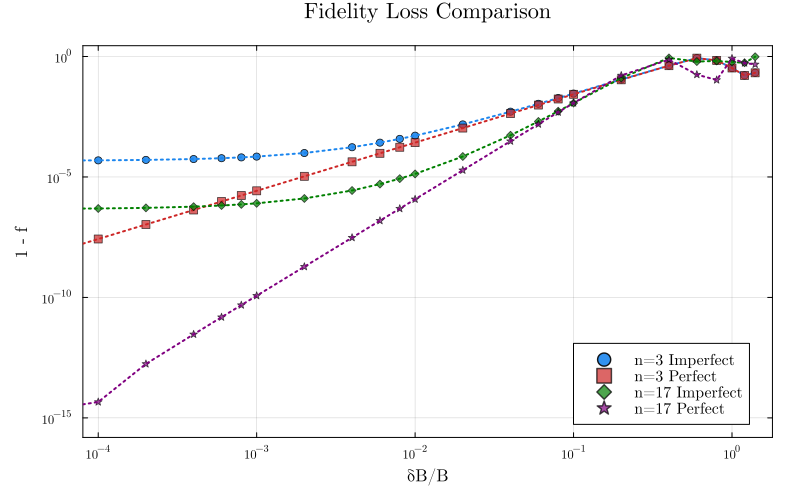

In [98]:
# Scatter plot for n=3 Imperfect
scatter(δB_t, squared_fidelity_distances_3, label="n=3 Imperfect",
        xlabel="δB/B", ylabel="1 - f", title="Fidelity Loss Comparison",
        marker=:circle, xscale=:log10, yscale=:log10,
        legend=:bottomright, markeralpha=0.9, markercolor=:dodgerblue2,
        markerstrokewidth=0.8, size=(800, 500), framestyle=:box, xlim=(8e-5, 1.8e0), margin=5mm, 
        fontfamily = "Computer Modern", fontstyle = :normal)

# Add a dotted line connecting the points for "Uncorrected Imperfect"
plot!(δB_t, squared_fidelity_distances_3, line=(:dot, 2), linecolor=:dodgerblue2, label=false)

# Scatter plot for n=3 Perfect
scatter!(δB_t, squared_fidelity_distances_perfect_3, label="n=3 Perfect",
         marker=:square, markercolor=:firebrick3,
         markerstrokewidth=0.8, markeralpha=0.7)

# Add a dotted line connecting the points for "Uncorrected Perfect"
plot!(δB_t, squared_fidelity_distances_perfect_3, line=(:dot, 2), linecolor=:firebrick3, label=false)

# Scatter plot for n=17 Imperfect
scatter!(δB_t, squared_fidelity_distances_17, label="n=17 Imperfect",
         marker=:diamond, markercolor=:green,
         markerstrokewidth=0.8, markeralpha=0.7)

# Add a dotted line connecting the points for n=17 Imperfect
plot!(δB_t, squared_fidelity_distances_17, line=(:dot, 2), linecolor=:green, label=false)

# Scatter plot for n=17 Perfect
scatter!(δB_t, squared_fidelity_distances_perfect_17, label="n=17 Perfect",
         marker=:star5, markercolor=:purple,
         markerstrokewidth=0.8, markeralpha=0.7)

# Add a dotted line connecting the points for n=17 Perfect
plot!(δB_t, squared_fidelity_distances_perfect_17, line=(:dot, 2), linecolor=:purple, label=false)

# Customize axis ticks
xticks!([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
yticks!([1e-15, 1e-10, 1e-5, 1e0])

# Adjust the size of the legend box
plot!(legendfontsize=10, legend=:bottomright)
